In [1]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 27.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import faiss
from collections import defaultdict
import time

In [6]:
train_metadata = pd.read_csv('/content/test_metadata_rootclass.csv')
train_embeddings = pd.read_csv('/content/test_embeddings_meanpool.csv')

# Merge the metadata and embeddings on 'video_id'
train_df = pd.merge(train_metadata, train_embeddings, on='video_id')
train_df['root_classes'] = train_df['root_classes'].apply(eval)
train_df

,video_id,start_time_seconds,end_time_seconds,labels,root_classes,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127
0,iZcPr3wgJCw,30.0,40.0,['Engine knocking'],[Engine],64.9,221.3,85.4,7.4,215.8,...,124.0,191.2,144.8,65.8,87.1,153.0,112.2,216.3,187.1,173.0
1,iZmn0dUXP9E,40.0,50.0,"['Toothbrush', 'Electric toothbrush']","[Domestic sounds, home sounds]",93.7,112.2,100.1,20.7,166.8,...,54.9,181.4,106.5,192.7,50.5,67.4,95.2,123.9,190.5,132.4
2,iZ2K_GPtc6g,30.0,40.0,"['Sine wave', 'Chirp tone']",[Other sourceless],170.6,72.8,107.5,83.9,118.0,...,96.5,204.1,215.9,80.7,77.4,20.7,80.1,190.3,42.6,146.3
3,iZtF1lUPbEQ,20.0,30.0,"['Fart', 'Buzz', 'Music']","[Wild animals, Digestive, Music, Onomatopoeia]",170.6,118.4,102.6,128.2,134.6,...,120.7,27.1,137.5,150.0,90.3,94.5,100.1,136.5,156.4,119.3
4,iZFRfh1Wjt8,420.0,430.0,"['Vehicle', 'Vehicle horn, car horn, honking',...","[Alarm, Vehicle]",73.9,166.3,82.6,17.5,230.2,...,91.4,149.5,149.7,134.8,124.3,62.7,146.1,166.0,52.4,85.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21777,2Cmn2lplGfc,30.0,40.0,"['Propeller, airscrew']",[Vehicle],59.7,189.7,13.3,18.3,179.3,...,255.0,214.7,253.7,112.6,123.7,90.4,110.9,138.4,58.5,113.1
21778,2ClQcAd-wJg,30.0,40.0,"['Speech', 'Buzzer']","[Alarm, Human voice]",55.0,147.8,237.5,223.2,126.1,...,65.6,122.0,178.2,192.2,198.1,175.9,237.6,61.6,182.2,153.4
21779,-Sclnq22t7o,30.0,40.0,"['Burping, eructation']",[Digestive],82.0,77.8,171.4,86.6,112.6,...,147.6,129.8,32.3,148.6,101.8,54.0,85.2,107.8,183.9,112.1
21780,-SD9DkKyOrY,30.0,40.0,"['Percussion', 'Drum kit', 'Drum', 'Snare drum...",[Music],180.4,107.9,81.7,80.9,99.4,...,42.1,33.7,0.7,233.8,150.8,93.2,255.0,128.7,137.1,230.7


In [7]:
test_metadata = pd.read_csv('/content/testing_samples_id_based_on_class_size.csv')
test_embeddings = pd.read_csv('/content/test_embeddings_meanpool.csv')

# Merge the metadata and embeddings on 'video_id'
test_df = pd.merge(test_metadata, test_embeddings, on='video_id')
test_df['root_classes'] = test_df['root_classes'].apply(eval)
test_df

,video_id,start_time_seconds,end_time_seconds,labels,root_classes,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127
0,FdeHk3CjgB0,0.0,10.0,"['Speech', 'Car', 'Glass', 'Breaking']","[Generic impact sounds, Glass, Vehicle, Human ...",42.5,127.6,131.9,56.0,220.6,...,153.2,166.3,129.0,141.2,197.9,73.9,105.3,151.0,67.7,123.6
1,WhI_e7hH99w,120.0,130.0,"['Speech', 'Glass']","[Glass, Human voice]",58.4,100.3,154.2,50.5,157.5,...,131.2,145.0,75.5,53.5,94.3,174.1,96.6,53.4,138.5,84.7
2,rBkHd299nY8,210.0,220.0,"['Music', 'Chink, clink']","[Glass, Music]",121.4,52.9,102.7,122.2,123.1,...,113.9,122.6,114.7,55.2,141.7,164.3,158.2,57.5,130.8,70.6
3,SVsz5CKZaUQ,160.0,170.0,['Shatter'],[Glass],104.9,98.1,136.0,159.7,82.4,...,179.3,108.4,82.0,131.5,108.6,131.3,141.5,149.0,214.0,73.0
4,fk6lhvFz-LA,150.0,160.0,['Glass'],[Glass],39.9,83.9,160.5,61.6,169.2,...,125.5,93.7,37.1,125.7,125.4,172.7,165.1,90.8,142.2,155.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3725,BGkXV9_wf9g,30.0,40.0,"['Speech', 'Animal', 'Domestic animals, pets',...","[Domestic animals, pets, Animal, Human voice]",94.0,111.3,168.8,72.9,171.0,...,39.4,73.9,95.6,151.9,154.0,64.3,122.8,161.4,170.2,186.7
3726,7gqGqbzLpZE,30.0,40.0,"['Animal', 'Domestic animals, pets', 'Dog', 'H...","[Wild animals, Domestic animals, pets, Animal]",86.3,74.9,152.2,54.0,102.3,...,40.2,130.8,115.9,149.4,111.6,87.3,232.1,184.2,145.3,40.1
3727,5KWTAq3GkfA,6.0,16.0,"['Animal', 'Domestic animals, pets', 'Cat', 'M...","[Domestic animals, pets, Animal]",96.4,96.4,175.3,71.5,153.5,...,141.6,141.1,59.0,81.2,131.7,103.9,141.9,59.0,130.3,167.7
3728,Lv-itTXoTiQ,500.0,510.0,"['Speech', 'Growling', 'Inside, small room']","[Wild animals, Domestic animals, pets, Acousti...",89.2,78.0,209.3,112.6,93.2,...,123.2,176.8,41.1,122.7,110.7,156.1,122.5,108.8,223.9,139.0


In [8]:
# Extract embeddings from dataframe
train_embeddings = train_df.iloc[:, 5:].values
train_labels = train_df['root_classes'].tolist()
test_embeddings = test_df.iloc[:, 5:].values
test_labels = test_df['root_classes'].tolist()
print(train_embeddings.shape)
print(test_embeddings.shape)

(21782, 128)
(3730, 128)


In [12]:
def perform_faiss_indexing(embeddings):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index

# perform Faiss indexing
model = perform_faiss_indexing(train_embeddings)

In [13]:
def cal_precisionK(query, neighbors):
    query_labels = set(query)
    relevant_cnt = 0
    for neigh in neighbors:
        neighbor_labels = set(neigh)
        if not query_labels.isdisjoint(neighbor_labels):
            relevant_cnt += 1
    return relevant_cnt / len(neighbors)

In [16]:
def faiss_evaluation(k=10):
  D, I = model.search(test_embeddings, k)
  result_labels = []
  for idxs in I:
    result_labels.append([train_labels[i] for i in idxs])
  return result_labels

In [29]:
# collect data for faiss
query_results = faiss_evaluation(k=100)

print(len(query_results))

3730


In [34]:
k_level = np.arange(5, 101, 5, dtype=int)
precision = defaultdict(list)

for k in k_level:
  for test_label, query_result in zip(test_labels, query_results):
    precision[k].append(cal_precisionK(test_label, query_result[:k]))

  print(f'overall precision at {k} is:', np.mean(precision[k]))

overall precision at 5 is: 0.7336193029490616
overall precision at 10 is: 0.6898659517426274
overall precision at 15 is: 0.6728328865058089
overall precision at 20 is: 0.6625469168900805
overall precision at 25 is: 0.6536729222520107
overall precision at 30 is: 0.6472743521000893
overall precision at 35 is: 0.6416085790884718
overall precision at 40 is: 0.6379021447721179
overall precision at 45 is: 0.6343521000893655
overall precision at 50 is: 0.6311528150134048
overall precision at 55 is: 0.6281062637094809
overall precision at 60 is: 0.6251519213583556
overall precision at 65 is: 0.6223468756444628
overall precision at 70 is: 0.6196361547299886
overall precision at 75 is: 0.617615728328865
overall precision at 80 is: 0.615338471849866
overall precision at 85 is: 0.6129222520107238
overall precision at 90 is: 0.6113255883229074
overall precision at 95 is: 0.6093579793988994
overall precision at 100 is: 0.6078176943699731


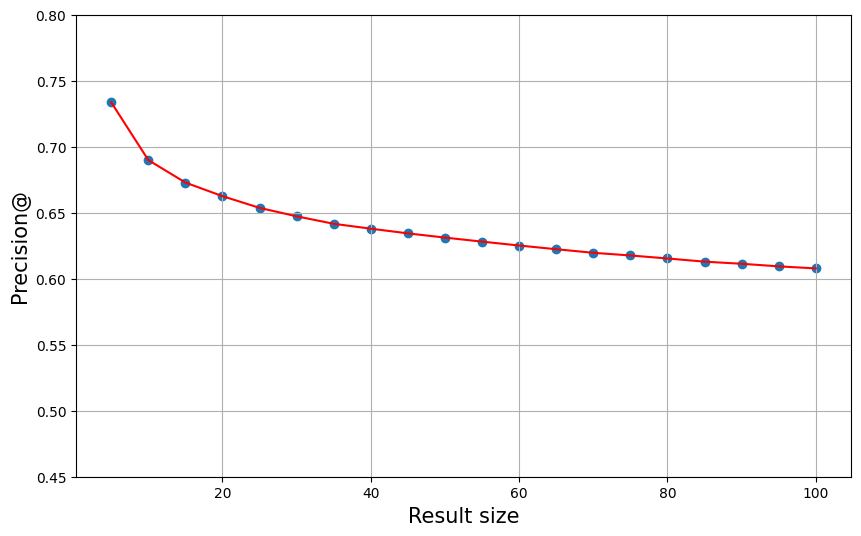

In [41]:
import matplotlib.pyplot as plt

keys_sorted = sorted(precision.keys())
values_sorted = [np.mean(precision[k]) for k in keys_sorted]

x = np.array(keys_sorted)
y = np.array(values_sorted)

plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.plot(x, y, color='red')
plt.xlabel('Result size', fontsize=15)
plt.ylabel('Precision@', fontsize=15)
plt.ylim(0.45, 0.8)
plt.grid(True)
plt.savefig('Precision.pdf')
plt.show()